In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("diabetes.csv")
df.shape

(768, 9)

In [3]:
data = df.drop('Outcome',axis=1)

In [4]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Columns: 8 entries, Pregnancies to Age
dtypes: float64(2), int64(6)
memory usage: 48.1 KB


In [5]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [6]:
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


Text(0.5, 1.0, 'Correlation value between ratings given for questions')

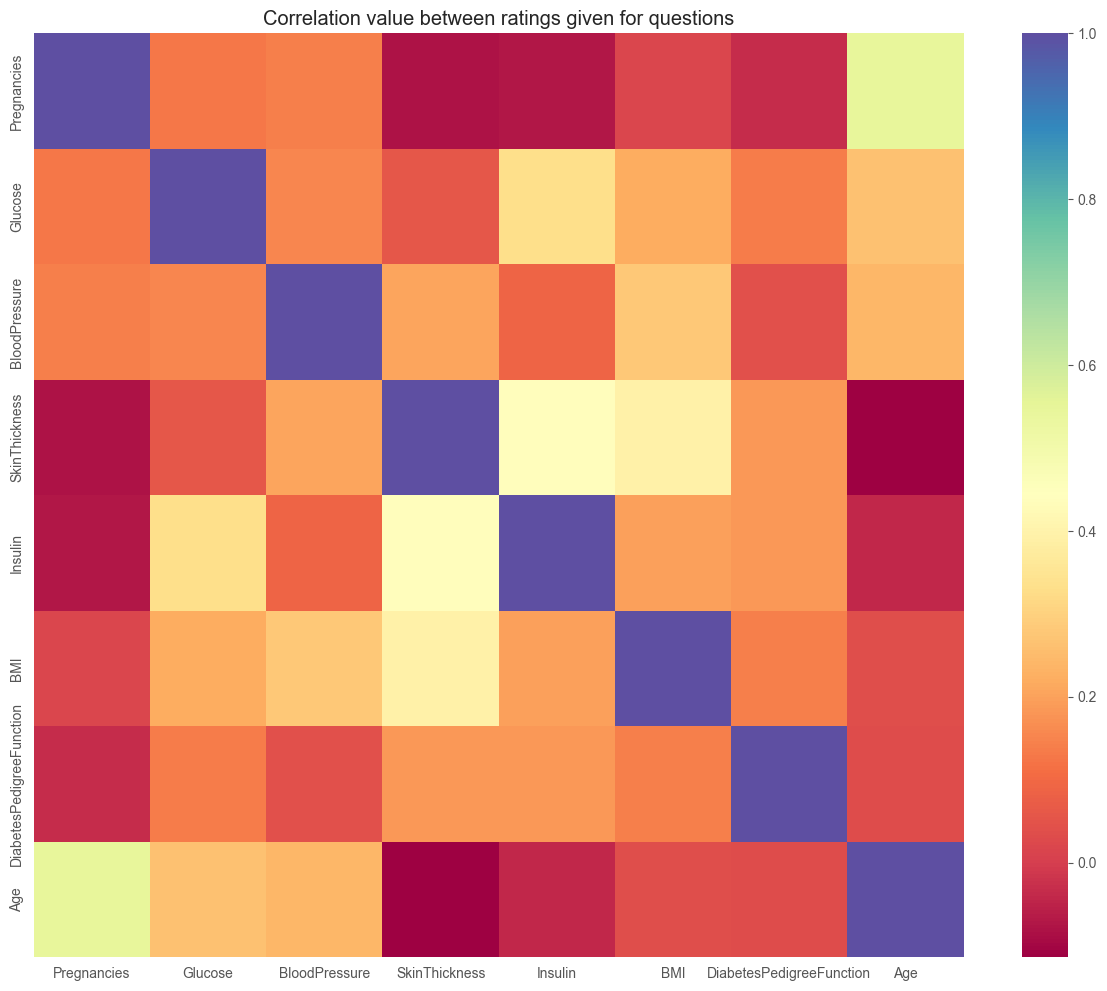

In [7]:
plt.figure(figsize=(15,12))
sns.heatmap(data.corr(),cmap='Spectral')
plt.title("Correlation value between ratings given for questions")

In [8]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi2,p = calculate_bartlett_sphericity(data)
print("Chi squared value : ",chi2)
print("p value : ",p)

Chi squared value :  948.2262232122048
p value :  1.2575496243955591e-181


In [9]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_vars,kmo_model = calculate_kmo(data)
print(kmo_model)

0.5889870819164513


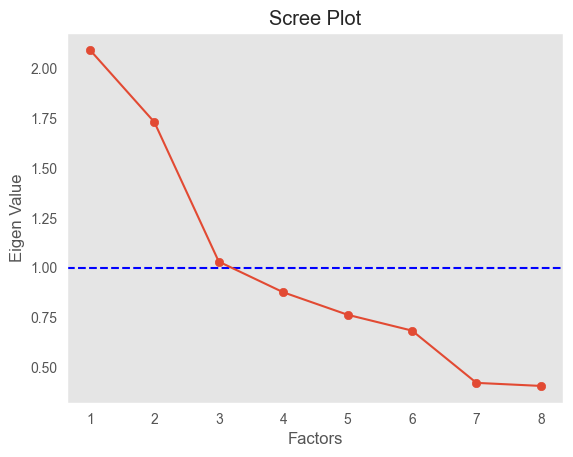

In [10]:
from factor_analyzer import FactorAnalyzer
n = data.shape[1]
fa = FactorAnalyzer(rotation = None,n_factors=n)
fa.fit(data)
ev,_ = fa.get_eigenvalues()
plt.scatter(range(1,n+1),ev)
plt.axhline(y=1, color='b', linestyle='--')
plt.plot(range(1,n+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid()

In [12]:
fa = FactorAnalyzer(n_factors=3,rotation='varimax')
fa.fit(data)
fa_load = pd.DataFrame(fa.loadings_,index=data.columns)

In [14]:
loadings = pd.DataFrame(fa.loadings_)
loadings.rename(columns = lambda x: 'Factor-' + str(x + 1), inplace=True)
loadings.index = data.columns
loadings

,Factor-1,Factor-2,Factor-3
Pregnancies,0.567933,-0.040564,0.013052
Glucose,0.272599,0.313673,0.175400
BloodPressure,0.237514,0.052885,0.393438
SkinThickness,-0.158431,0.334956,0.512033
Insulin,-0.071597,0.988676,0.138293
BMI,0.027947,0.116657,0.707150
DiabetesPedigreeFunction,0.005053,0.186854,0.178031
Age,0.947997,0.026038,0.027773


In [15]:
def color_factor_importance(val):
    if np.abs(val) > 0.4:
        color = 'green'
    elif np.abs(val) > 0.3 and np.abs(val) <= 0.4:
        color = 'blue'
    else:
        color = 'red'
    return 'color: %s' % color

loadings.style.applymap(color_factor_importance)

,Factor-1,Factor-2,Factor-3
Pregnancies,0.567933,-0.040564,0.013052
Glucose,0.272599,0.313673,0.175400
BloodPressure,0.237514,0.052885,0.393438
SkinThickness,-0.158431,0.334956,0.512033
Insulin,-0.071597,0.988676,0.138293
BMI,0.027947,0.116657,0.707150
DiabetesPedigreeFunction,0.005053,0.186854,0.178031
Age,0.947997,0.026038,0.027773


In [16]:
segments = loadings[loadings >= .4].fillna(loadings[loadings <= -.4])
segments

,Factor-1,Factor-2,Factor-3
Pregnancies,0.567933,NaN,NaN
Glucose,NaN,NaN,NaN
BloodPressure,NaN,NaN,NaN
SkinThickness,NaN,NaN,0.512033
Insulin,NaN,0.988676,NaN
BMI,NaN,NaN,0.707150
DiabetesPedigreeFunction,NaN,NaN,NaN
Age,0.947997,NaN,NaN


In [17]:
communalities = fa.get_communalities()
communalities = pd.DataFrame(communalities, index=data.T.index, columns=['communalities'])
communalities

,communalities
Pregnancies,0.324363
Glucose,0.203466
BloodPressure,0.214003
SkinThickness,0.399474
Insulin,1.001731
BMI,0.514451
DiabetesPedigreeFunction,0.066635
Age,0.900148


In [18]:
# Check variance
factorVariance = pd.DataFrame(fa.get_factor_variance())
factorVariance.rename(columns = lambda x: 'Factor-' + str(x + 1), inplace=True)
factorVariance.index = ['SS Loadings', 'Proportion Variance', 'Cumulative Variance']
factorVariance

,Factor-1,Factor-2,Factor-3
SS Loadings,1.383003,1.241710,0.999559
Proportion Variance,0.172875,0.155214,0.124945
Cumulative Variance,0.172875,0.328089,0.453034


In [22]:
X = df.copy().drop('Outcome',axis=1)
y = df['Outcome'].copy()
X.shape, y.shape

((768, 8), (768,))

In [23]:
from sklearn.decomposition import FactorAnalysis
transformer = FactorAnalysis(n_components=3, rotation='varimax', random_state=0)
X_transformed = transformer.fit_transform(X)
X_transformed.shape

(768, 3)

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

k = 10
model = LogisticRegression()
scores = cross_val_score(model,X_transformed,y,cv=k)
print(f"{k} fold - cross validated scores: {scores}")
print(f"Average accuracy scores: {scores.mean()}")

10 fold - cross validated scores: [0.72727273 0.67532468 0.71428571 0.68831169 0.75324675 0.75324675
 0.76623377 0.77922078 0.77631579 0.77631579]
Average accuracy scores: 0.7409774436090226
